In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

In [3]:
mpl.rcParams['image.cmap'] = 'gray'
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [5]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [6]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [7]:
model = Model(m, nh, 10)

In [8]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [9]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [10]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [11]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [12]:
loss_func = F.cross_entropy
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [13]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.0662,  0.0088,  0.1560, -0.1311, -0.0730,  0.1144,  0.1670, -0.0882,
         -0.1070, -0.0087], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [14]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3089, grad_fn=<NllLossBackward>)

In [15]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1173, grad_fn=<NllLossBackward>), tensor(0.9531))

\_\_setattr__ is interesting, we change it as per our needs and then call super().\_\_attr__(k,v) to let it have its original functionality back

In [16]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_") : self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [17]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [19]:
mdl._modules

{'l1': Linear(in_features=784, out_features=50, bias=True),
 'l2': Linear(in_features=50, out_features=10, bias=True)}

Understanding repr from this [link](https://www.journaldev.com/22460/python-str-repr-functions)

In [20]:
class Person():
    def __init__(self, name, age):
        self.name = name
        self.age = age
        
    def __repr__(self):
        return f"name:{self.name} and age:{self.age}"

In [21]:
person = Person('Bob',5);person

name:Bob and age:5

In [22]:
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [23]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

In [24]:
for o in mdl.parameters():print(f"{o.shape}")

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [25]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

In [26]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [27]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [28]:
model = Model(layers)

In [29]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [30]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [31]:
model = SequentialModel(layers)

In [32]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [33]:
layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [34]:
nn.ModuleList(layers)

ModuleList(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [35]:
model = nn.Sequential(nn.ModuleList(layers))

In [36]:
model

Sequential(
  (0): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [37]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [38]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [39]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad*self.lr
                
    def zero_grad(self):
        for p in self.params:p.grad.data.zero_()

In [40]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
opt = Optimizer(model.parameters())

In [41]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [42]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0481, grad_fn=<NllLossBackward>), tensor(1.))

In [43]:
from torch import optim

In [44]:
optim.SGD.step??

In [45]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [46]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.2861, grad_fn=<NllLossBackward>)

In [47]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [48]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0907, grad_fn=<NllLossBackward>), tensor(0.9375))

In [49]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self,i): return self.x[i],self.y[i]

In [50]:
train_ds, valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)

In [51]:
xb,yb = train_ds[0:5]

In [52]:
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [53]:
model, opt = get_model()

In [54]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs:i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred,yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [55]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0773, grad_fn=<NllLossBackward>), tensor(1.))

In [56]:
class DataLoader():
    def __init__(self,ds,bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0,len(self.ds),self.bs): yield self.ds[i:i+self.bs]

In [90]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [91]:
xb,yb = next(iter(valid_dl))

In [92]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

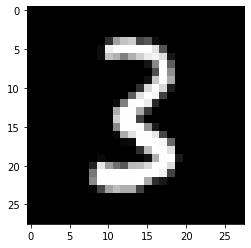

In [94]:
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(8)

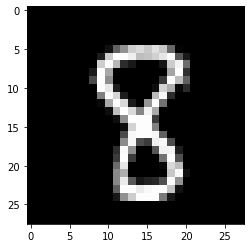

In [95]:
plt.imshow(xb[1].view(28,28))
yb[1]

In [61]:
model,opt = get_model()

In [96]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [97]:
fit()

In [64]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0605, grad_fn=<NllLossBackward>), tensor(1.))

In [65]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [66]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [98]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [99]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1432, grad_fn=<NllLossBackward>), tensor(0.9375))

In [69]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [70]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [71]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.3438) tensor(0.8987)
1 tensor(0.1956) tensor(0.9414)
2 tensor(0.1123) tensor(0.9670)
3 tensor(0.1276) tensor(0.9639)
4 tensor(0.1049) tensor(0.9707)


In [72]:
assert acc>0.9

### Cross Entropy Loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.